In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import OrderedDict
from torch.utils.data import TensorDataset, DataLoader, random_split
from networks import *
from dropout import *
from utils import get_dist, eval_error, get_dist_deup, evaluate_and_plot
from data import generate_data
from train import train_main_model

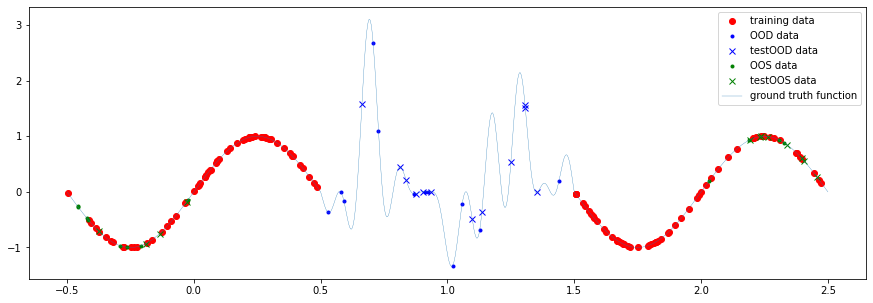

In [3]:
x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test, oos_y_test, ood_x_test, ood_y_test = generate_data(128, 24, 24, seed=3, plot=True)

full_X = torch.cat((x, ood_x, oos_x))
full_Y= torch.cat((y, ood_y, oos_y))
full_data = TensorDataset(full_X, full_Y)

test_data = TensorDataset(torch.cat((ood_x_test, oos_x_test)), torch.cat((ood_y_test, oos_y_test)))
oos_ood = torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))

In [4]:
def inv_sigmoid(p):
    return np.log(p / (1 - p))

### train a model with dropout

tensor(-2.1972, requires_grad=True)


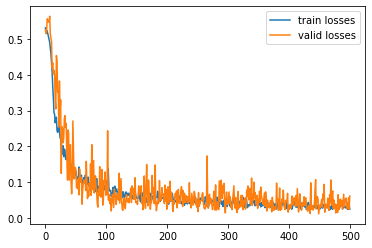

In [6]:
epochs = 500
lr = 1e-3
batch_size = 32
n_hidden = 64
hidden_layers = 4

p = torch.tensor(inv_sigmoid(.1), requires_grad=True)
model = ModelWithFixedDropout(n_hidden=n_hidden, hidden_layers=hidden_layers,
                              dropout_module=FixedDropout, p=p, tau=1e-3, soft=False)
optimizer = torch.optim.Adam([param for name, param in model.named_parameters() if 'dropout' not in name],
                             lr=lr)
train_data = TensorDataset(x, y)
losses, valid_losses = train_main_model(model, train_data, TensorDataset(oos_x, oos_y), lr=lr)
plt.plot(losses, label='train losses')
plt.plot(valid_losses, label='valid losses')
plt.legend()
plt.show()

# how does the dropout prarameter affect the predicted uncertainty

In [128]:
from copy import deepcopy
model2 = deepcopy(model)

invsigmoid_ps = torch.linspace(-3, 0.5, 2000)
errors = []
true_error = ((model2.eval()(full_data[:][0]) - full_data[:][1]) ** 2).mean()
predicted_error_per_x_s = []

for p in invsigmoid_ps:
   
    model2.model.dropout1.p = p
    model2.model.dropout2.p = p
    model2.model.dropout3.p = p
    model2.model.dropout4.p = p
    model2.model.dropout5.p = p
    model2.eval()
    y_mean = model2(full_data[:][0])
    model2.train()
    y_noisy = torch.cat([model2(full_data[:][0]) for _ in range(10)], 1)
    predicted_error_per_x = (y_mean - y_noisy).pow(2).mean(1).detach()
    predicted_error_per_x_s.append(predicted_error_per_x)
    true_error_per_x = (y_mean - full_data[:][1]).pow(2).detach().squeeze()
    errors.append(loss_fn(predicted_error_per_x, true_error_per_x))

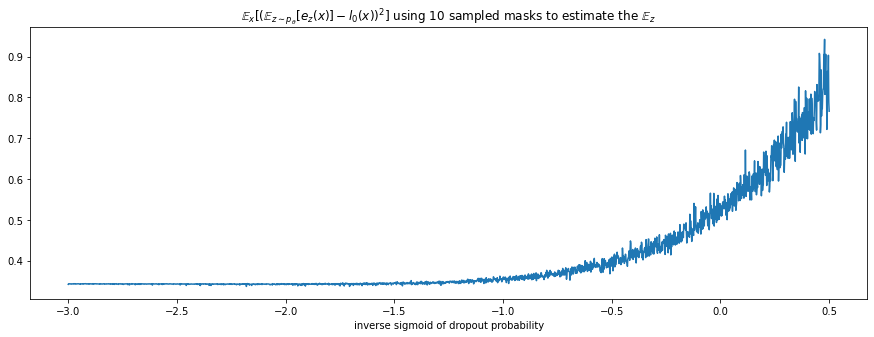

In [129]:
plt.figure(figsize = (15, 5))
plt.plot(invsigmoid_ps[:2000], errors[:2000])
plt.xlabel('inverse sigmoid of dropout probability')
plt.title(r'$\mathbb{E}_x [(\mathbb{E}_{z\sim p_\theta} [e_{z}(x)] - l_0(x))^2]$ using 10 sampled masks to estimate the $\mathbb{E}_z$')
plt.show()

### Examples of predicted uncertainties with diffrent p

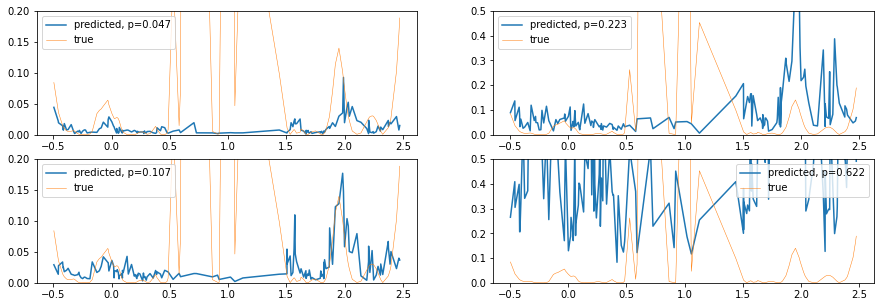

In [139]:
idxs = torch.argsort(full_data[:][0].squeeze())
fig, axes = plt.subplots(2, 2, figsize=(15, 5))
axes[0,0].plot(full_data[:][0][idxs], predicted_error_per_x_s[0][idxs], label='predicted, p={:.3f}'.format(torch.sigmoid(invsigmoid_ps[0]).item()))
axes[0,0].plot(full_data[:][0][idxs], true_error_per_x[idxs], linewidth=.5, label='true')
axes[0,0].set_ylim(0, 0.2)
axes[0,0].legend()

axes[0,1].plot(full_data[:][0][idxs], predicted_error_per_x_s[1000][idxs], label='predicted, p={:.3f}'.format(torch.sigmoid(invsigmoid_ps[1000]).item()))
axes[0,1].plot(full_data[:][0][idxs], true_error_per_x[idxs], linewidth=.5, label='true')
axes[0,1].set_ylim(0, 0.5)
axes[0,1].legend()

axes[1,0].plot(full_data[:][0][idxs], predicted_error_per_x_s[500][idxs], label='predicted, p={:.3f}'.format(torch.sigmoid(invsigmoid_ps[500]).item()))
axes[1,0].plot(full_data[:][0][idxs], true_error_per_x[idxs], linewidth=.5, label='true')
axes[1,0].set_ylim(0, 0.2)
axes[1,0].legend()

axes[1,1].plot(full_data[:][0][idxs], predicted_error_per_x_s[1999][idxs], label='predicted, p={:.3f}'.format(torch.sigmoid(invsigmoid_ps[1999]).item()))
axes[1,1].plot(full_data[:][0][idxs], true_error_per_x[idxs], linewidth=.5, label='true')
axes[1,1].set_ylim(0, 0.5)
axes[1,1].legend()

plt.show()